In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("scraped.csv")

In [3]:
df.describe()

,category,source,title,text
count,225,225,225,225
unique,3,6,223,223
top,Business,BBC Health,Toy sellers keep close watch on social media ban,UK toy sales have risen for the first time in ...
freq,75,75,2,2


In [3]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

df["all_text"] = df["title"] +" "+ df["text"]
df['clean_text'] = df['all_text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


X = df['clean_text']
y = df['category']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_df=0.9,
        min_df=5,
        ngram_range=(1, 2)
    )),
    ('clf', MultinomialNB(alpha=0.1))
])





In [5]:
text_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [6]:

# 5. Test and Evaluate
y_pred = text_clf.predict(X_test)

print("--- Model Performance ---")
print(classification_report(y_test, y_pred))

--- Model Performance ---
               precision    recall  f1-score   support

     Business       0.93      0.93      0.93        15
Entertainment       0.93      0.87      0.90        15
       Health       0.94      1.00      0.97        15

     accuracy                           0.93        45
    macro avg       0.93      0.93      0.93        45
 weighted avg       0.93      0.93      0.93        45



In [7]:
text_clf.predict(["Doctors warn about rising diabetes rates linked to obesity"])


array(['Business'], dtype='<U13')

In [8]:
text_clf.predict(["The actor won an award for his performance in the new Netflix series"])


array(['Entertainment'], dtype='<U13')

In [9]:
text_clf.predict(["Stock markets fell sharply after inflation data shocked investors"])


array(['Business'], dtype='<U13')

In [10]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, log_loss, roc_auc_score
)
import matplotlib.pyplot as plt

Overall Accuracy: 0.9333
Log Loss (Lower is better): 0.2146
Weighted ROC-AUC: 0.9911


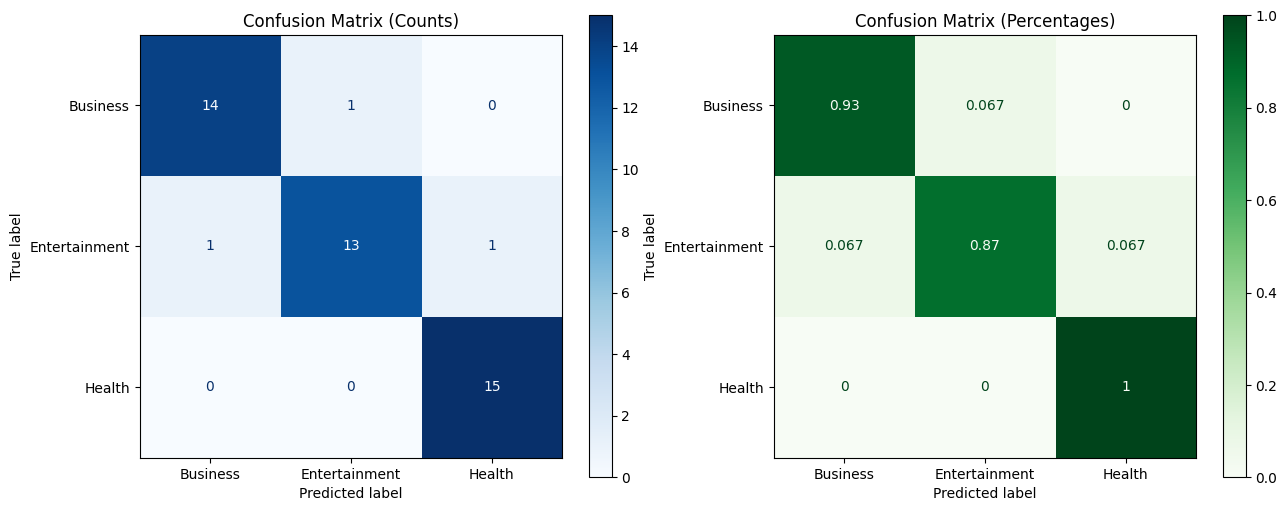

In [11]:
y_pred = text_clf.predict(X_test)
y_proba = text_clf.predict_proba(X_test)  # Needed for Log Loss and ROC-AUC


print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log Loss (Lower is better): {log_loss(y_test, y_proba):.4f}")


auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC: {auc:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix (Counts)")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[1], cmap='Greens', normalize='true')
ax[1].set_title("Confusion Matrix (Percentages)")

plt.show()

In [12]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")

Balanced Accuracy: 0.9333
Cohen's Kappa: 0.9000
MCC: 0.9007


In [13]:
def predict_with_confidence(new_text):
    probs = text_clf.predict_proba([new_text])[0]
    classes = text_clf.classes_
    

    best_index = probs.argmax()
    prediction = classes[best_index]
    confidence = probs[best_index]
    
    print(f"Text: '{new_text[:50]}...'")
    print(f"Prediction: {prediction} ({confidence:.2%} confidence)")
    
    for label, prob in zip(classes, probs):
        print(f" - {label}: {prob:.2%}")

predict_with_confidence("The central bank raised interest rates to combat inflation.")

Text: 'The central bank raised interest rates to combat i...'
Prediction: Business (85.28% confidence)
 - Business: 85.28%
 - Entertainment: 6.00%
 - Health: 8.72%
